# Ensemble: variables (over sea-ice and ocean)

## Imports & defaults

In [1]:
import libs.local
import libs.plot
import libs.vars
import matplotlib
import numpy as np
import warnings

matplotlib.rcParams.update({ 'font.size': 18 })
warnings.filterwarnings('ignore')

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'prra'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = 'precipitation, rainfall (dashed), and snowfall (dotted) over sea-ice'
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f''

In [3]:
ensemble_prra_time_series = libs.local.get_ensemble_series(variable_id, experiment)
ensemble_pr_time_series = libs.local.get_ensemble_series('pr', experiment)
ensemble_prsn_time_series = libs.local.get_ensemble_series('prsn', experiment)
ensemble_evspsbl_time_series = libs.local.get_ensemble_series('evspsbl', experiment)

# per month
ensemble_evspsbl_time_series *= 30 
ensemble_pr_time_series *= 30
ensemble_prra_time_series *= 30
ensemble_prsn_time_series *= 30

ensemble_tas_time_series = libs.local.get_ensemble_series('tas', experiment)
ensemble_tos_time_series = libs.local.get_ensemble_series('tos', experiment)

ensemble_siconc_time_series = libs.local.get_ensemble_series('siconc', experiment)
ensemble_siconc_time_series /= 2e5

# ensemble_sithick_time_series = libs.local.get_ensemble_series('sithick', experiment)
# ensemble_sithick_time_series *= 10

# ensemble_sisnthick_time_series =  libs.local.get_ensemble_series('sisnthick', experiment)
# ensemble_sisnthick_time_series *= 100

# ensemble_simass_time_series = libs.local.get_ensemble_series('simass', experiment)

for variable in ensemble_tas_time_series:
    ensemble_siconc_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }
    #ensemble_sithick_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }
    #ensemble_sisnthick_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }

time_slices = libs.vars.default_time_slices()

## Monthly variability

### Full region (time)

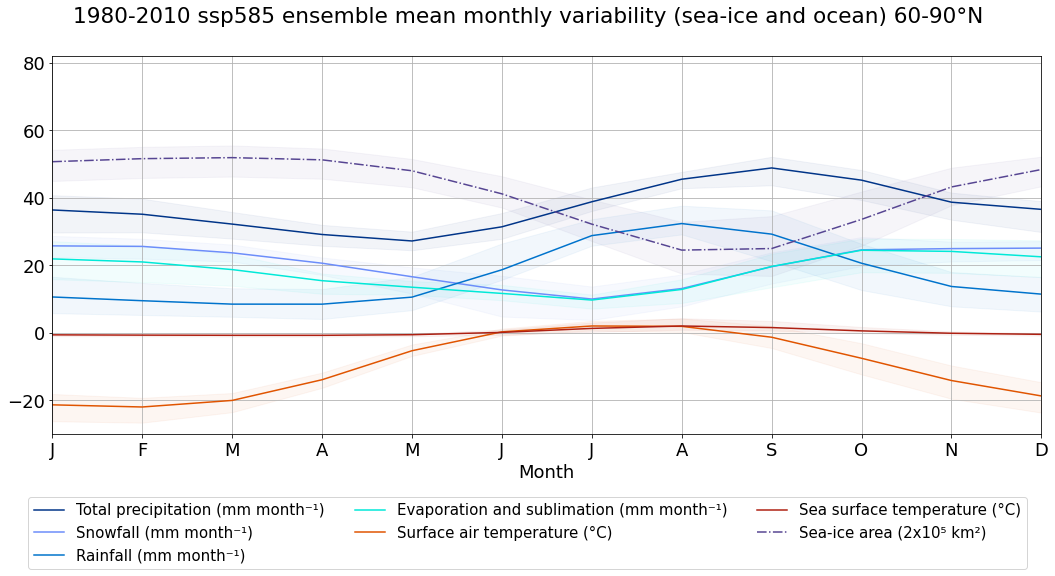

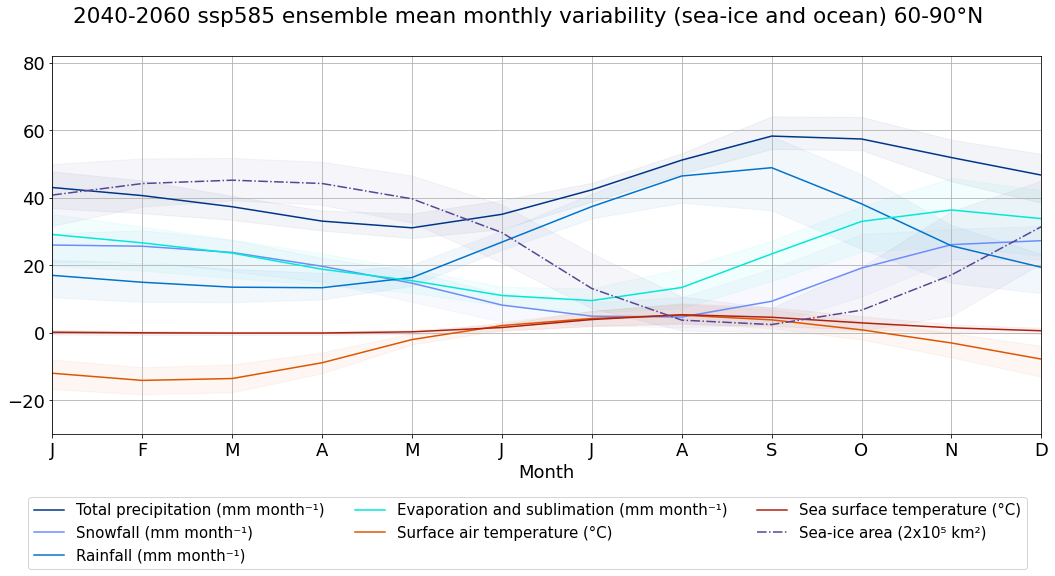

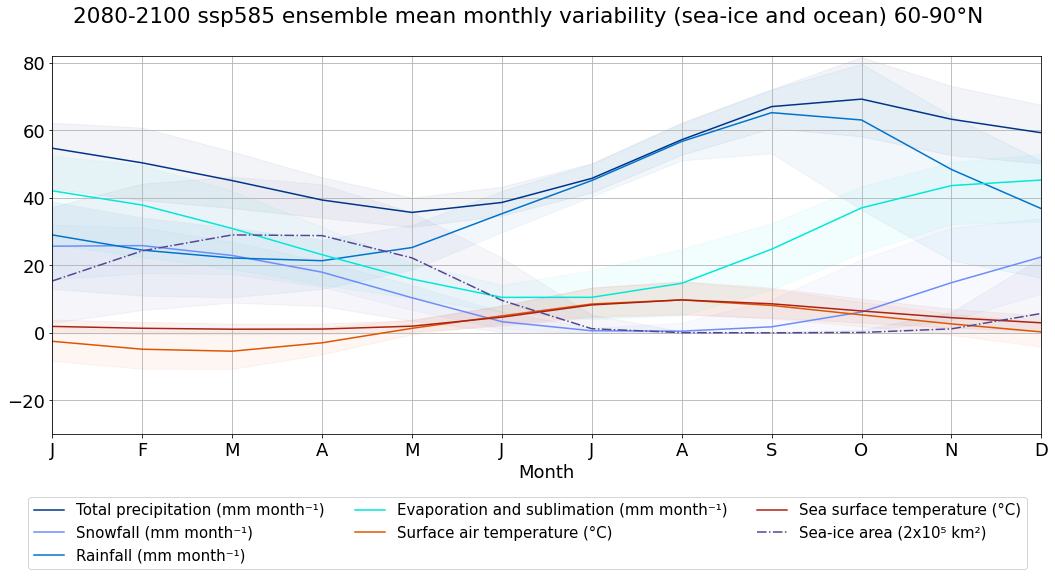

In [4]:
import numpy as np

for s in time_slices:
    s_label = s['label']
    
    slice_pr = ensemble_pr_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    slice_pr['Ensemble mean'].attrs['label'] = 'Total precipitation (mm month⁻¹)'
    slice_pr['Ensemble mean'].attrs['color'] = '#003488'
    
    slice_prsn = ensemble_prsn_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    slice_prsn['Ensemble mean'].attrs['label'] = 'Snowfall (mm month⁻¹)'
    slice_prsn['Ensemble mean'].attrs['color'] = '#6c8dfa'
    
    slice_prra = ensemble_prra_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    slice_prra['Ensemble mean'].attrs['label'] = 'Rainfall (mm month⁻¹)'
    slice_prra['Ensemble mean'].attrs['color'] = '#0073cc'
    
    slice_evspsbl = ensemble_evspsbl_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    slice_evspsbl['Ensemble mean'].attrs['label'] = 'Evaporation and sublimation (mm month⁻¹)'
    slice_evspsbl['Ensemble mean'].attrs['color'] = '#00e9d8'

    slice_tas = ensemble_tas_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    slice_tas['Ensemble mean'].attrs['label'] = 'Surface air temperature (°C)'
    slice_tas['Ensemble mean'].attrs['color'] = '#e05400'
    
    slice_tos = ensemble_tos_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    slice_tos['Ensemble mean'].attrs['label'] = 'Sea surface temperature (°C)'
    slice_tos['Ensemble mean'].attrs['color'] = '#ae2012'
    
    slice_siconc = ensemble_siconc_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    slice_siconc['Ensemble mean'].attrs['label'] = 'Sea-ice area (2x10⁵ km²)'
    slice_siconc['Ensemble mean'].attrs['color'] = '#564592'
    
#     slice_sithick = ensemble_sithick_time_series.sel(**s['slice']).groupby('time.month').mean('time')
#     slice_sithick['Ensemble mean'].attrs['label'] = 'Sea-ice thickness (dm)'
#     slice_sithick['Ensemble mean'].attrs['color'] = '#927EA0'
    
#     slice_sisnthick = ensemble_sisnthick_time_series.sel(**s['slice']).groupby('time.month').mean('time')
#     slice_sisnthick['Ensemble mean'].attrs['label'] = 'Sea-ice snow layer thickness (cm)'
#     slice_sisnthick['Ensemble mean'].attrs['color'] = '#CDC4D4'
    
    variables = [
        slice_pr,
        slice_prsn,
        slice_prra,
        slice_evspsbl,
        slice_tas,
        slice_tos,
        slice_siconc,
        #slice_sithick,
        #slice_sisnthick
    ]
    
    fig = libs.plot.monthly_variability(
        variables,
        cols=3,
        legend_below=True,
        title=f'{s_label} {experiment} ensemble mean monthly variability (sea-ice and ocean) 60-90°N',
        ylabel=time_series_y_label,
        yrange=(-30, 82),
        variables=['Ensemble mean']
    )
        
    for data in variables:
        data_min = data.to_array('min').min('min')
        data_max = data.to_array('max').max('max')
        
        fig.axes[0].fill_between(
            np.arange(1, 13),
            data_min.values,
            data_max.values,
            alpha=0.05,
            color=data['Ensemble mean'].attrs['color'],
            zorder=-1
        )

### Anomaly

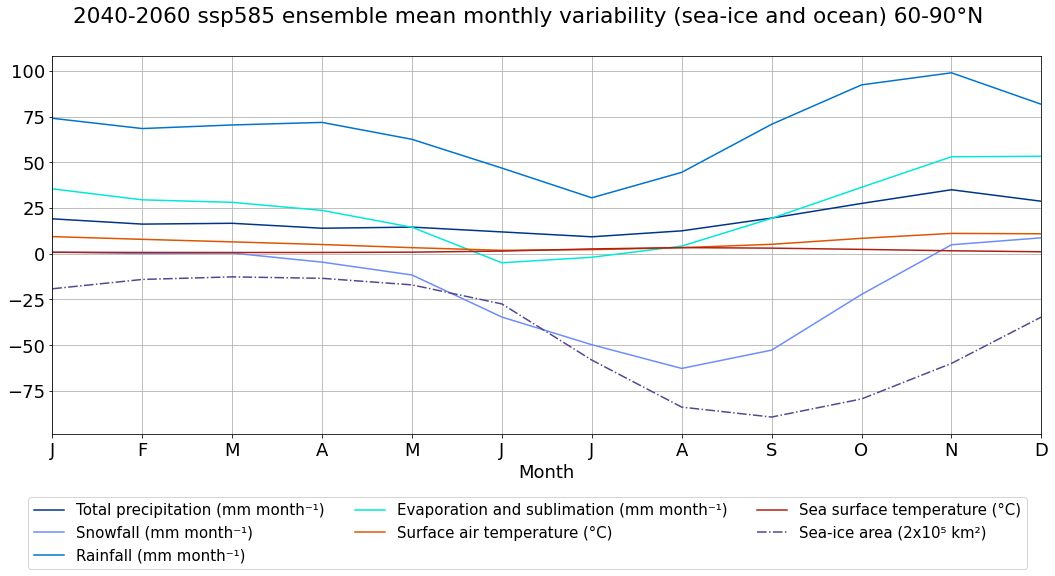

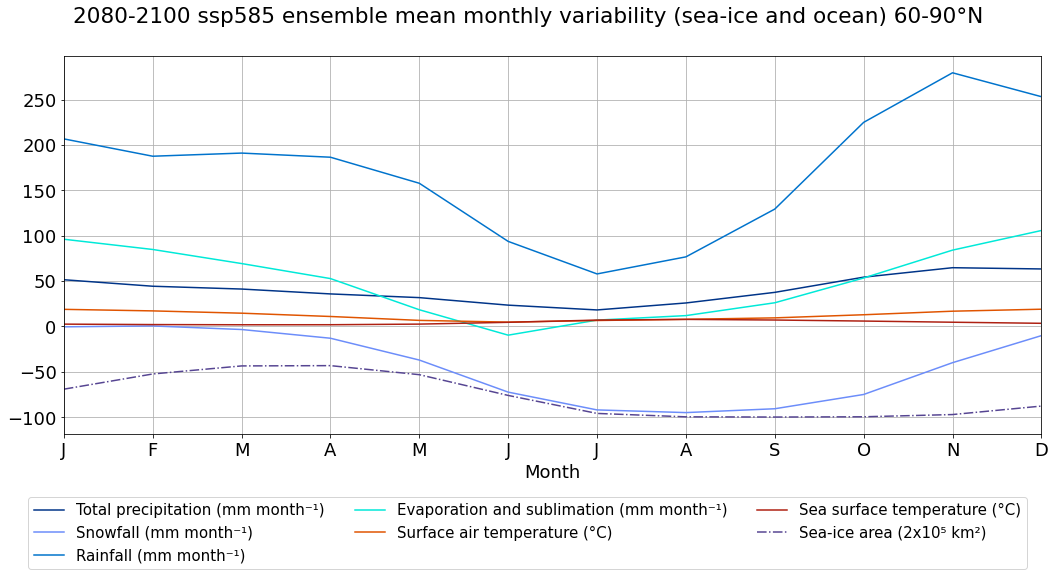

In [5]:
def ensemble_mean(data):
    ensemble_mean = None
    if 'Ensemble mean' in data:
        del data['Ensemble mean']

    for i, item in enumerate(data):
        ensemble_mean = ensemble_mean + data[item] if i > 0 else data[item]

    ensemble_mean /= len(data)
    ensemble_mean.attrs['color'] = '#000'
    ensemble_mean.attrs['label'] = 'Ensemble mean'
    data['Ensemble mean'] = ensemble_mean
    
    return data


def preprocess_data(data, s, relative=False):
    slice_data = libs.analysis.climatology_monthly(data, '1980-01-01', '2011-01-01', relative=relative)
    slice_data = slice_data.sel(**s['slice']).groupby('time.month').mean('time', skipna=True)
    slice_data = ensemble_mean(slice_data)
        
    return slice_data


for s in time_slices[1:]:
    s_label = s['label']
    
    slice_pr = preprocess_data(ensemble_pr_time_series, s, relative=True)
    slice_pr['Ensemble mean'].attrs['label'] = 'Total precipitation (mm month⁻¹)'
    slice_pr['Ensemble mean'].attrs['color'] = '#003488'

    slice_prsn = preprocess_data(ensemble_prsn_time_series, s, relative=True)
    slice_prsn['Ensemble mean'].attrs['label'] = 'Snowfall (mm month⁻¹)'
    slice_prsn['Ensemble mean'].attrs['color'] = '#6c8dfa'

    slice_prra = preprocess_data(ensemble_prra_time_series, s, relative=True)
    slice_prra['Ensemble mean'].attrs['label'] = 'Rainfall (mm month⁻¹)'
    slice_prra['Ensemble mean'].attrs['color'] = '#0073cc'
    
    slice_evspsbl = preprocess_data(ensemble_evspsbl_time_series, s, relative=True)
    slice_evspsbl['Ensemble mean'].attrs['label'] = 'Evaporation and sublimation (mm month⁻¹)'
    slice_evspsbl['Ensemble mean'].attrs['color'] = '#00e9d8'

    slice_tas = preprocess_data(ensemble_tas_time_series, s)
    slice_tas['Ensemble mean'].attrs['label'] = 'Surface air temperature (°C)'
    slice_tas['Ensemble mean'].attrs['color'] = '#e05400'

    slice_tos = preprocess_data(ensemble_tos_time_series, s)
    slice_tos['Ensemble mean'].attrs['label'] = 'Sea surface temperature (°C)'
    slice_tos['Ensemble mean'].attrs['color'] = '#ae2012'

    slice_siconc = preprocess_data(ensemble_siconc_time_series, s, relative=True)
    slice_siconc['Ensemble mean'].attrs['label'] = 'Sea-ice area (2x10⁵ km²)'
    slice_siconc['Ensemble mean'].attrs['color'] = '#564592'

#     slice_sithick = preprocess_data(ensemble_sithick_time_series, s)
#     slice_sithick['Ensemble mean'].attrs['label'] = 'Sea-ice thickness (0.1 m)'
#     slice_sithick['Ensemble mean'].attrs['color'] = '#7f2ccb'

#     slice_sisnthick = preprocess_data(ensemble_sisnthick_time_series, s)
#     slice_sisnthick['Ensemble mean'].attrs['label'] = 'Sea-ice snow layer thickness (cm)'
#     slice_sisnthick['Ensemble mean'].attrs['color'] = '#ff84e8'
    
    variables = [
        slice_pr,
        slice_prsn,
        slice_prra,
        slice_evspsbl,
        slice_tas,
        slice_tos,
        slice_siconc,
        #slice_sithick,
        #slice_sisnthick
    ]
    
    fig = libs.plot.monthly_variability(
        variables,
        cols=3,
        legend_below=True,
        title=f'{s_label} {experiment} ensemble mean monthly variability (sea-ice and ocean) 60-90°N',
        ylabel=time_series_y_label,
        #yrange=(-30, 82),
        variables=['Ensemble mean']
    )
        
#     for data in variables:
#         data_min = data.to_array('min').min('min')
#         data_max = data.to_array('max').max('max')
        
#         fig.axes[0].fill_between(
#             np.arange(1, 13),
#             data_min.values,
#             data_max.values,
#             alpha=0.05,
#             color=data['Ensemble mean'].attrs['color'],
#             zorder=-1
#         )

### Full region (each model)

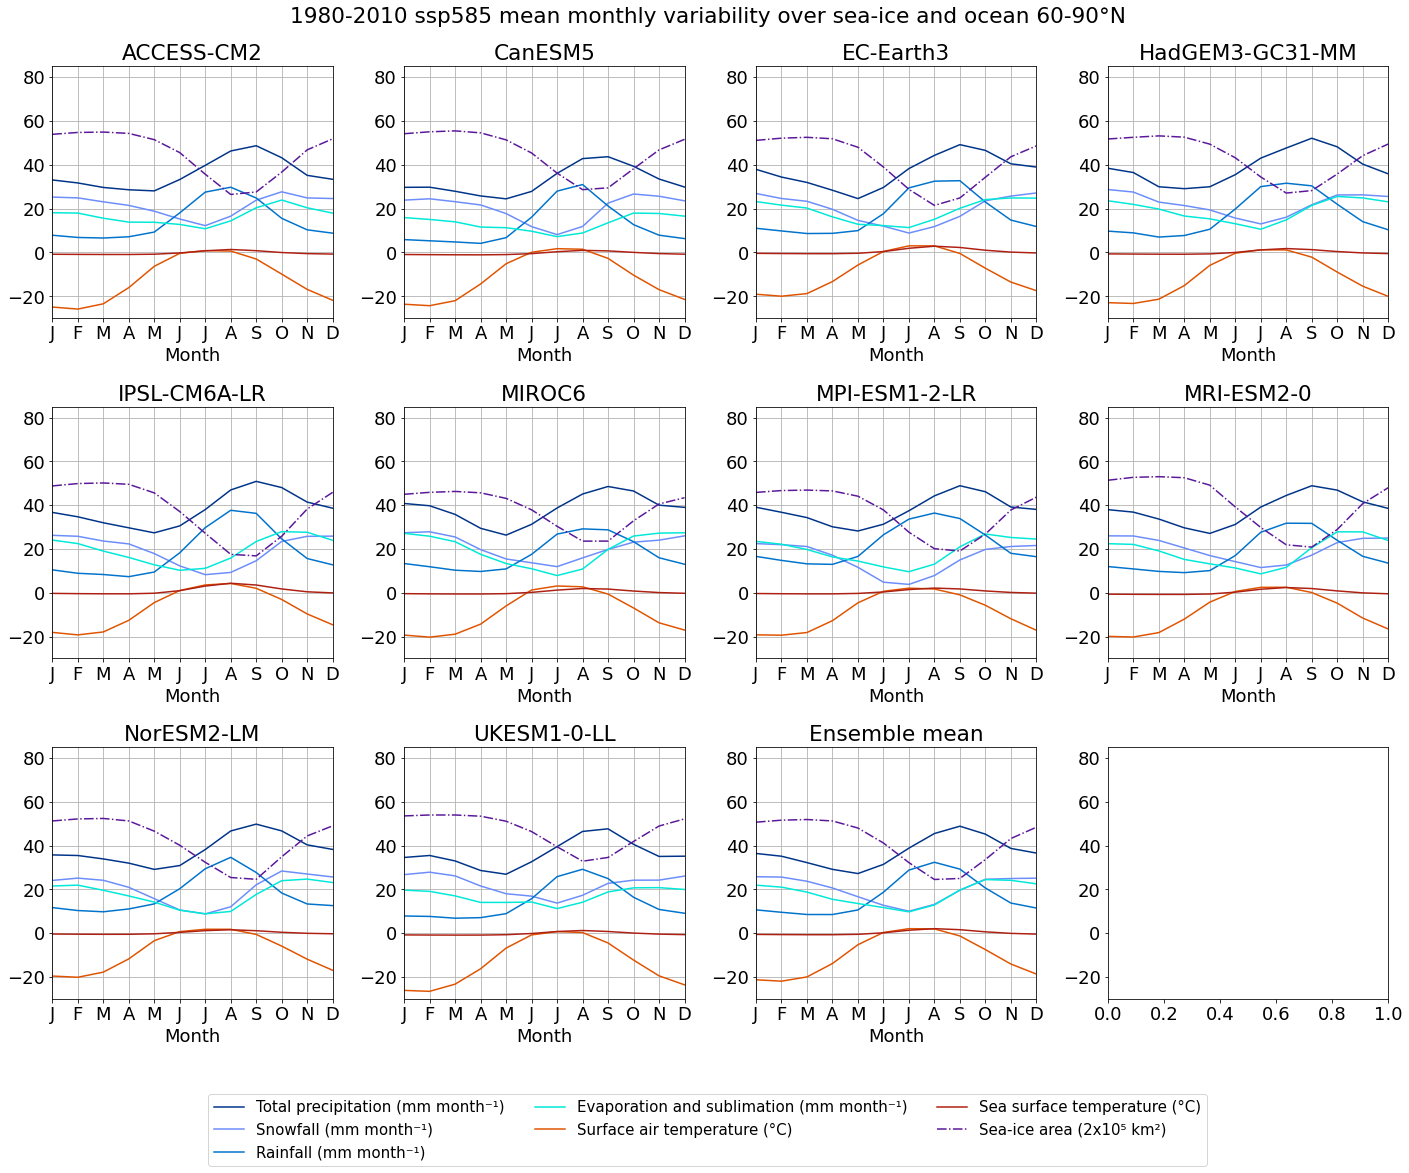

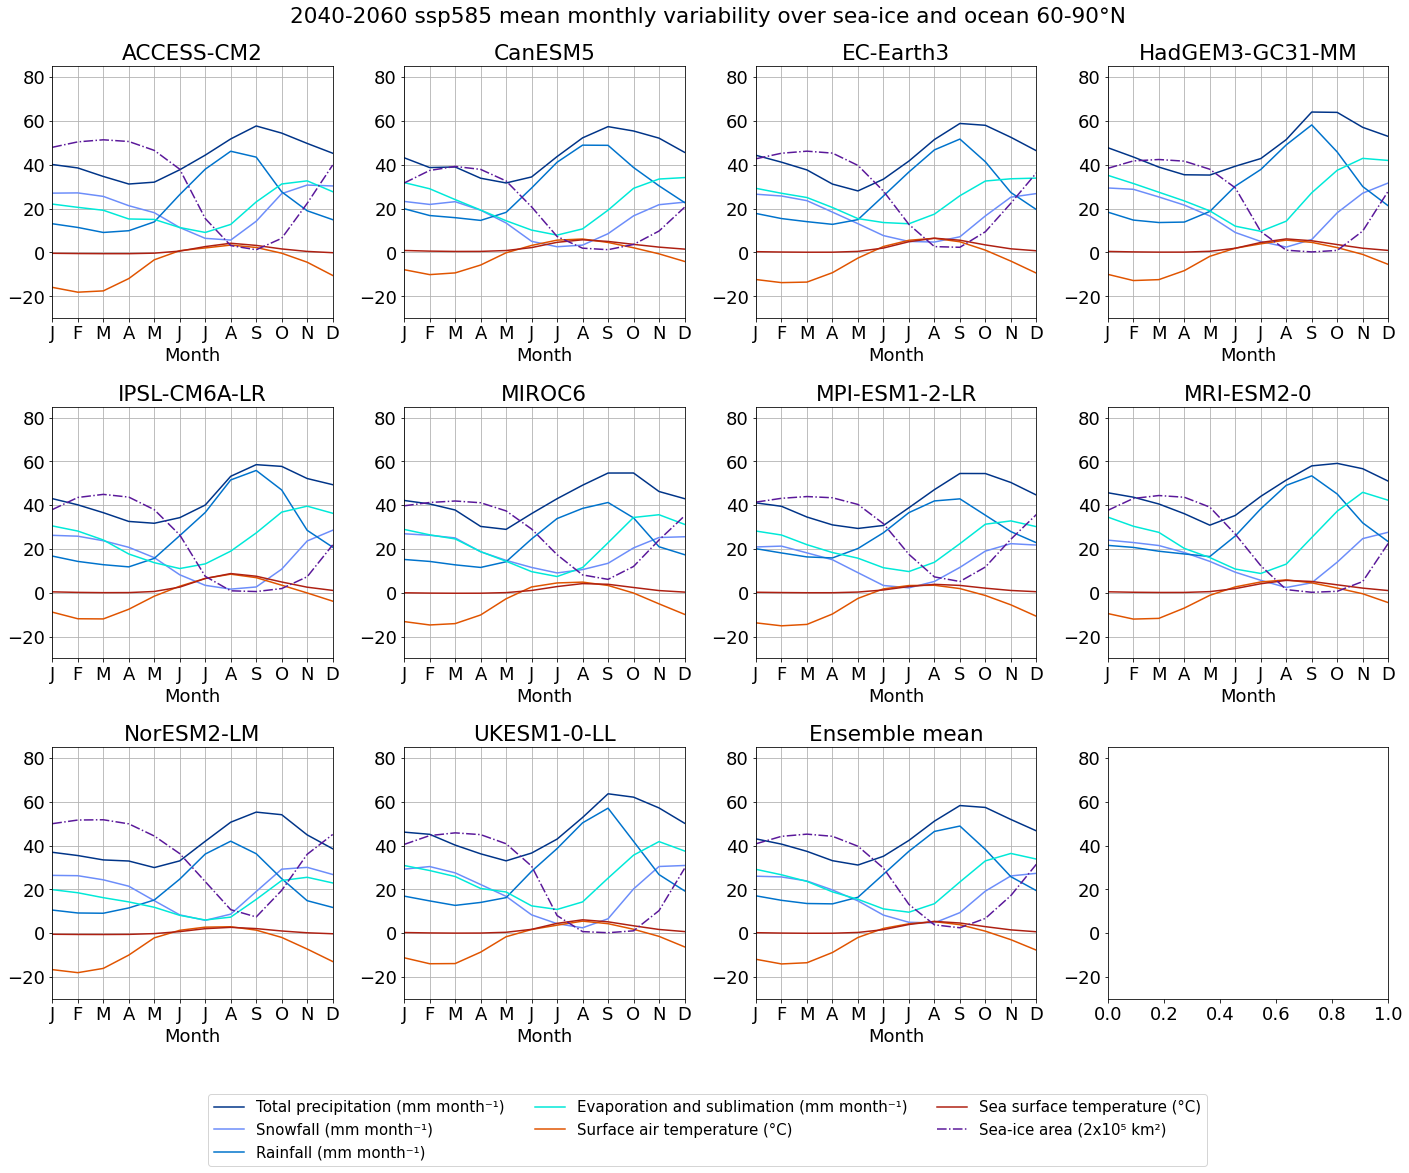

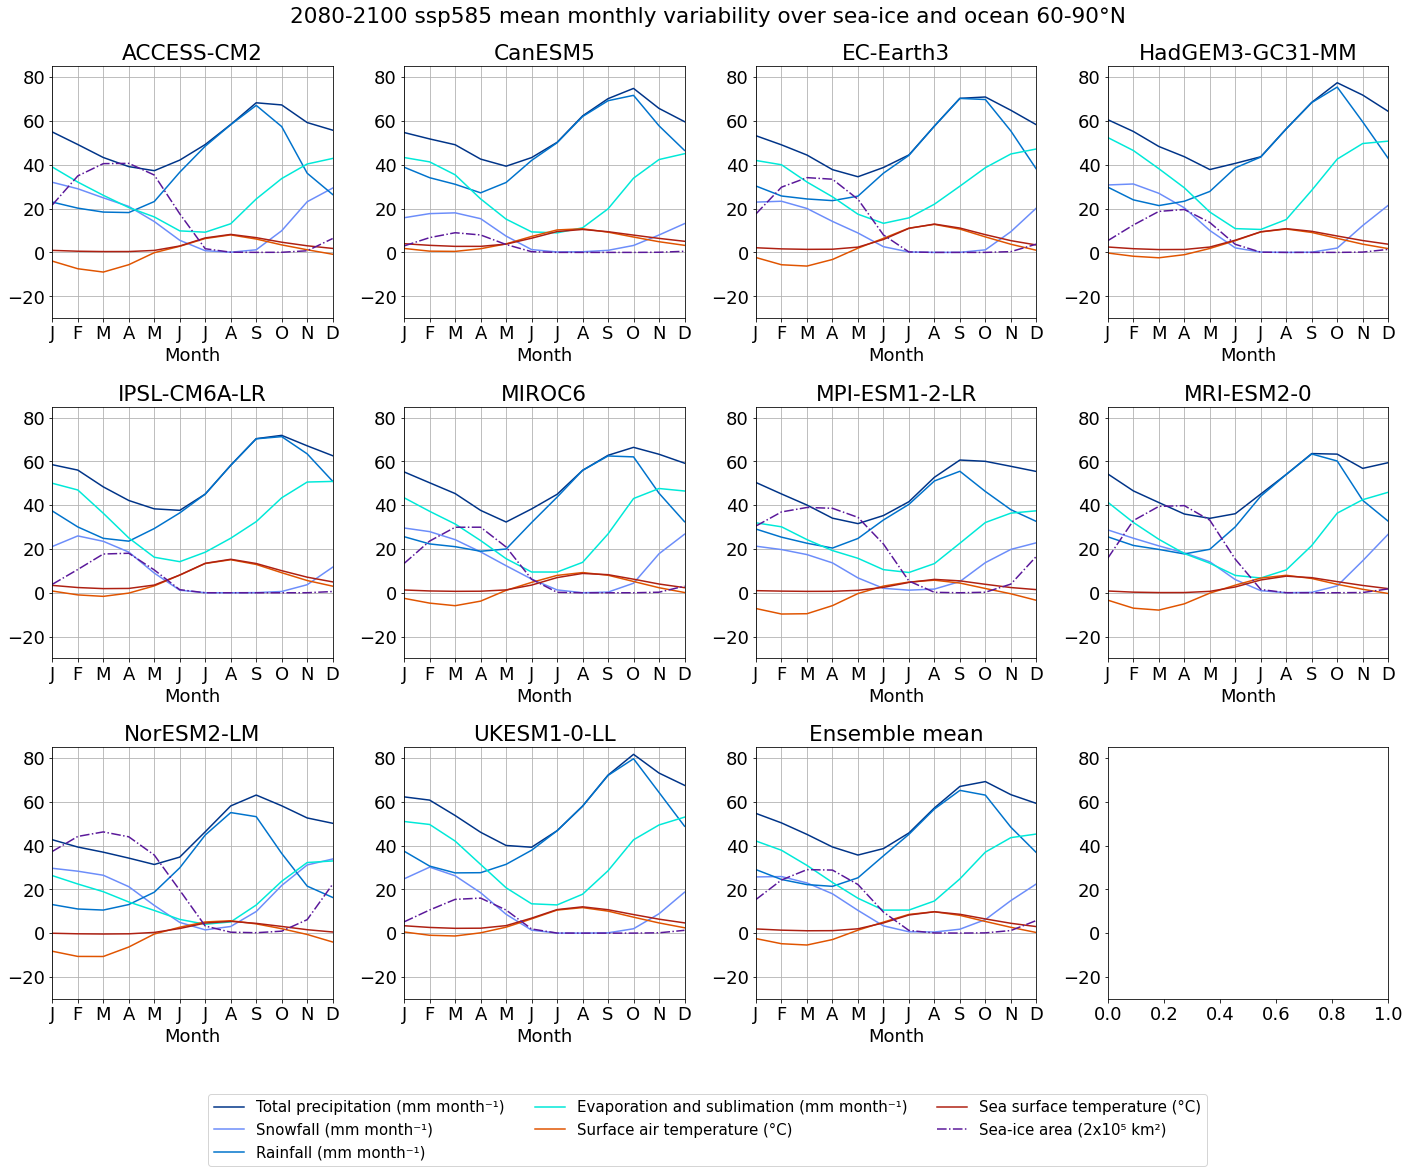

In [6]:
for s in time_slices:
    s_label = s['label']
    arr = []

    for model in ensemble_pr_time_series:      
        slice_pr = ensemble_pr_time_series.sel(**s['slice']).groupby('time.month').mean('time')
        slice_pr[model].attrs['label'] = 'Total precipitation (mm month⁻¹)'
        slice_pr[model].attrs['color'] = '#003488'

        slice_prsn = ensemble_prsn_time_series.sel(**s['slice']).groupby('time.month').mean('time')
        slice_prsn[model].attrs['label'] = 'Snowfall (mm month⁻¹)'
        slice_prsn[model].attrs['color'] = '#6c8dfa'

        slice_prra = ensemble_prra_time_series.sel(**s['slice']).groupby('time.month').mean('time')
        slice_prra[model].attrs['label'] = 'Rainfall (mm month⁻¹)'
        slice_prra[model].attrs['color'] = '#0073cc'
        
        slice_evspsbl = ensemble_evspsbl_time_series.sel(**s['slice']).groupby('time.month').mean('time')
        slice_evspsbl[model].attrs['label'] = 'Evaporation and sublimation (mm month⁻¹)'
        slice_evspsbl[model].attrs['color'] = '#00e9d8'

        slice_tas = ensemble_tas_time_series.sel(**s['slice']).groupby('time.month').mean('time')
        slice_tas[model].attrs['label'] = 'Surface air temperature (°C)'
        slice_tas[model].attrs['color'] = '#e05400'
        
        slice_tos = ensemble_tos_time_series.sel(**s['slice']).groupby('time.month').mean('time')
        slice_tos[model].attrs['label'] = 'Sea surface temperature (°C)'
        slice_tos[model].attrs['color'] = '#ae2012'

        slice_siconc = ensemble_siconc_time_series.sel(**s['slice']).groupby('time.month').mean('time')
        slice_siconc[model].attrs['label'] = 'Sea-ice area (2x10⁵ km²)'
        slice_siconc[model].attrs['color'] = '#5a189a'

#         slice_sithick = ensemble_sithick_time_series.sel(**s['slice']).groupby('time.month').mean('time')
#         slice_sithick[model].attrs['label'] = 'Sea-ice thickness (0.5e1)'
#         slice_sithick[model].attrs['color'] = '#927EA0'

#         slice_sisnthick = ensemble_sisnthick_time_series.sel(**s['slice']).groupby('time.month').mean('time')
#         slice_sisnthick[model].attrs['label'] = 'Sea-ice snow layer thickness (0.5e-1)'
#         slice_sisnthick[model].attrs['color'] = '#CDC4D4'
        
        model_variables = [
            slice_pr[model],
            slice_prsn[model],
            slice_prra[model],
            slice_evspsbl[model],
            slice_tas[model],
            slice_tos[model],
            slice_siconc[model],
            #slice_sithick[model],
            #slice_sisnthick[model]
        ]

        arr.append(model_variables)

    libs.plot.monthly_variability_model(
        arr,
        cols=3,
        legend_below=True,
        shape=(3, 4),
        title=f'{s_label} {experiment} mean monthly variability over sea-ice and ocean 60-90°N',
        ylabel=time_series_y_label,
        yrange=(-30, 85),
    )

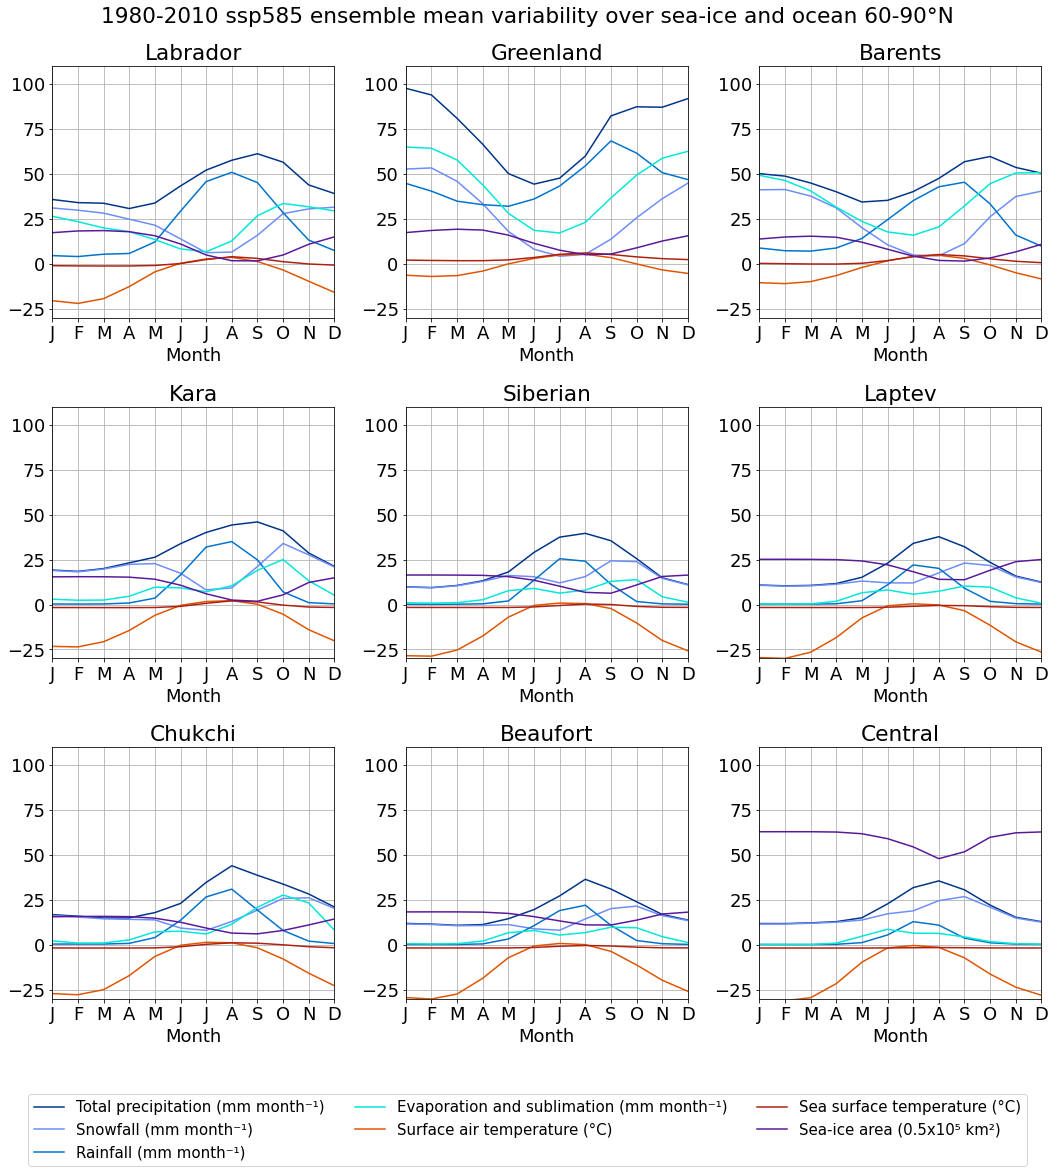

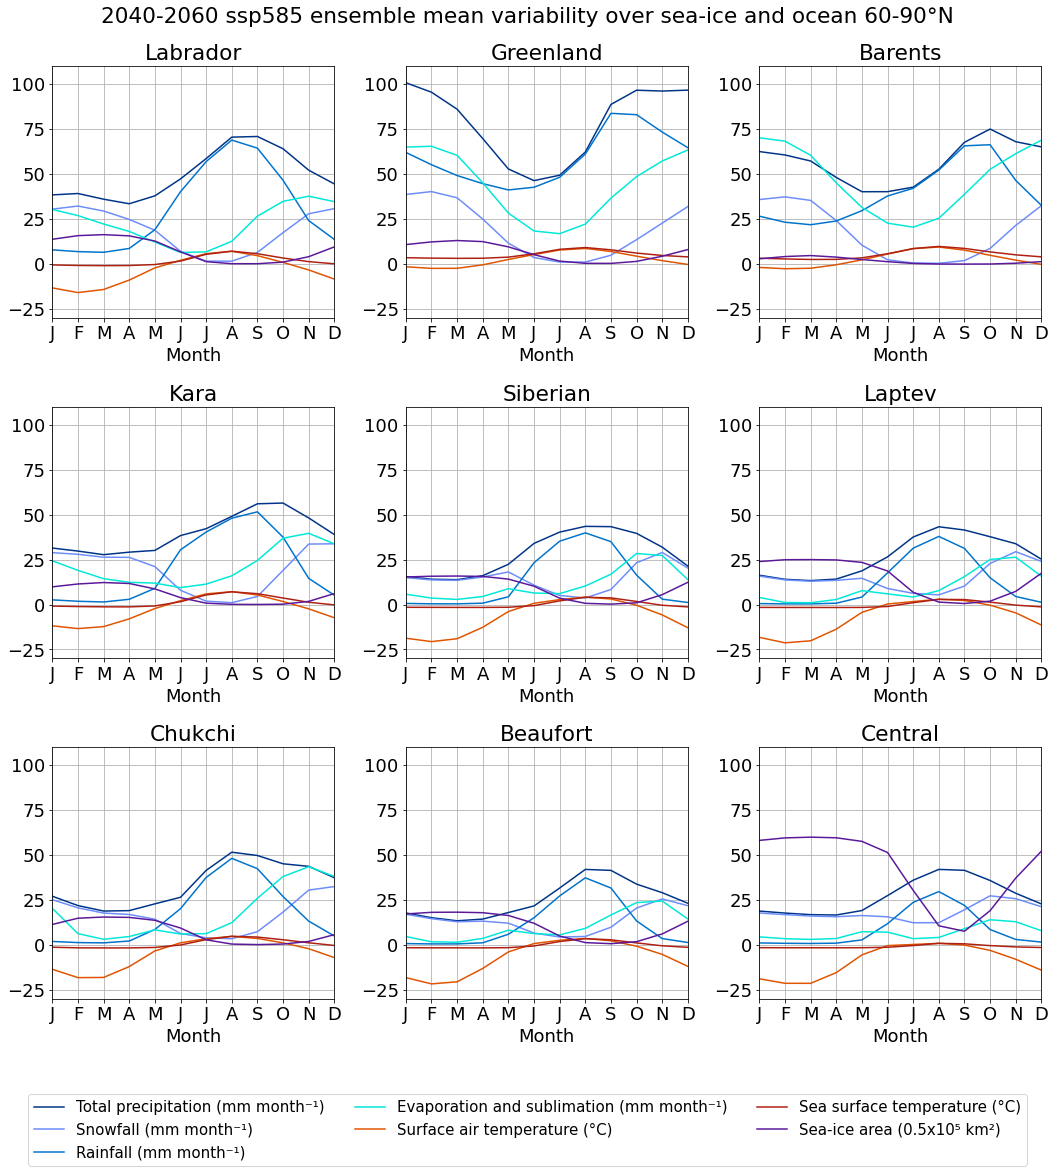

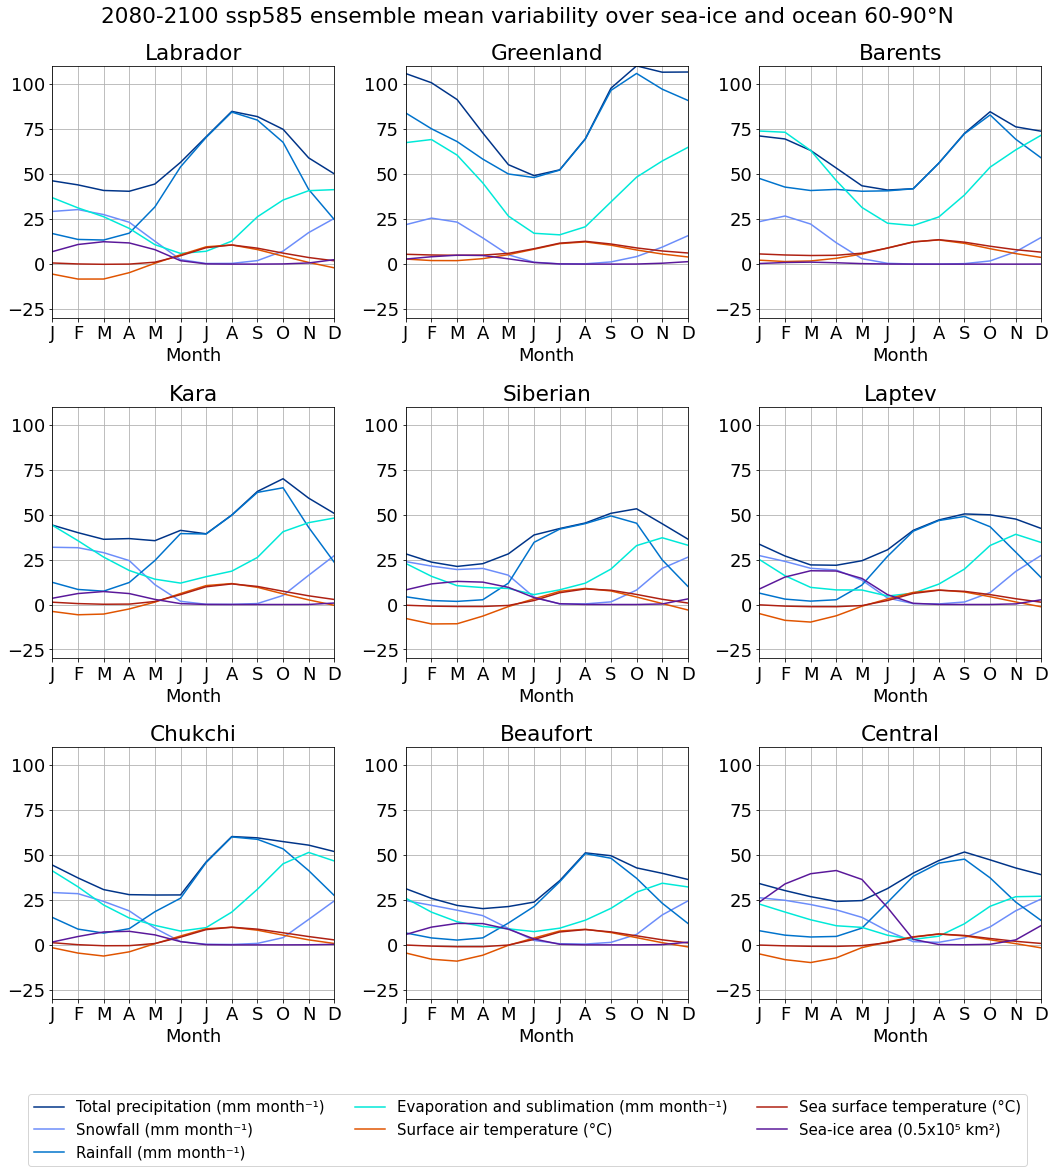

In [7]:
regions_pr = libs.local.get_ensemble_regional_series('pr', experiment)
regions_prra = libs.local.get_ensemble_regional_series('prra', experiment)
regions_prsn = libs.local.get_ensemble_regional_series('prsn', experiment)
regions_evspsbl = libs.local.get_ensemble_regional_series('evspsbl', experiment)
regions_tas = libs.local.get_ensemble_regional_series('tas', experiment)
regions_tos = libs.local.get_ensemble_regional_series('tos', experiment)
regions_siconc = libs.local.get_ensemble_regional_series('siconc', experiment)

for s in time_slices:
    s_label = s['label']
    arr = []
    for i, data_prra in enumerate(regions_prra):
        data_pr_slice = regions_pr[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_pr_slice *= 30
        data_pr_slice['Ensemble mean'].attrs['label'] = 'Total precipitation (mm month⁻¹)'
        data_pr_slice['Ensemble mean'].attrs['color'] = '#003488'
        
        data_prsn_slice = regions_prsn[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_prsn_slice *= 30
        data_prsn_slice['Ensemble mean'].attrs['label'] = 'Snowfall (mm month⁻¹)'
        data_prsn_slice['Ensemble mean'].attrs['color'] = '#6c8dfa'
        
        data_prra_slice = data_prra.sel(**s['slice']).groupby('time.month').mean('time')
        data_prra_slice *= 30
        data_prra_slice['Ensemble mean'].attrs['label'] = 'Rainfall (mm month⁻¹)'
        data_prra_slice['Ensemble mean'].attrs['color'] = '#0073cc'
        
        data_evspsbl_slice = regions_evspsbl[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_evspsbl_slice *= 30
        data_evspsbl_slice['Ensemble mean'].attrs['label'] = 'Evaporation and sublimation (mm month⁻¹)'
        data_evspsbl_slice['Ensemble mean'].attrs['color'] = '#00e9d8'

        data_siconc_slice = regions_siconc[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_siconc_slice /= 0.5e5
        data_siconc_slice['Ensemble mean'].attrs['label'] = 'Sea-ice area (0.5x10⁵ km²)'
        data_siconc_slice['Ensemble mean'].attrs['color'] = '#5a189a'

        data_tas_slice = regions_tas[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_tas_slice['Ensemble mean'].attrs['label'] = 'Surface air temperature (°C)'
        data_tas_slice['Ensemble mean'].attrs['color'] = '#e05400'
        
        data_tos_slice = regions_tos[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_tos_slice['Ensemble mean'].attrs['label'] = 'Sea surface temperature (°C)'
        data_tos_slice['Ensemble mean'].attrs['color'] = '#ae2012'

        arr.append([
            data_pr_slice,
            data_prsn_slice,
            data_prra_slice,
            data_evspsbl_slice,
            data_tas_slice,
            data_tos_slice,
            data_siconc_slice
        ])

    libs.plot.monthly_variability_regional(
        arr,
        cols=3,
        legend_below=True,
        title=f'{s_label} {experiment} ensemble mean variability over sea-ice and ocean 60-90°N',
        variables=['Ensemble mean'],
        ylabel=time_series_y_label,
        yrange=(-30, 110)
    )